In [1]:
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
#import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ry, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Energy_Estimate, make_Hamiltonian, eval_hamiltonian, group_paulis
from qiskit.tools.qi.pauli import Pauli

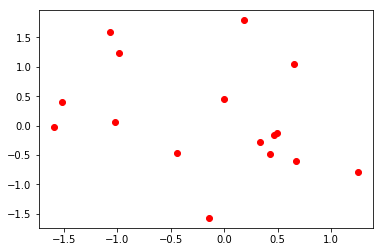

In [8]:
# generate n samples w.r.t bivariate Gaussian
n = 16


mean = [0.0, 0.0]
cov = [[1.0, 0], [0, 1.0]]
X = np.random.multivariate_normal(mean, cov, (2, n))
X = X[:, :, 0]
plt.plot(X[0], X[1],'ro')

generate weight matrix, element at [i,j] is the distance from ith vertex to jth vertex

In [9]:
w = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            pass
        elif j > i: # upper right triangle
            w[i][j] = la.norm(X[:, i] - X[:, j])
        else:
            w[i][j] = w[j][i]
print(w)

[[0.         1.27324424 1.69400229 1.27563589 3.32805571 2.56086552
  2.32592536 3.29326593 2.15400452 1.80646697 2.33382116 2.32569404
  0.35950083 1.5563883  2.80204363 1.52805957]
 [1.27324424 0.         2.54203063 2.20304356 2.79711273 2.29372675
  1.94630052 3.37909796 2.34929485 0.88286116 2.0730919  1.96703465
  1.29813501 1.34870071 2.44774045 2.10970343]
 [1.69400229 2.54203063 0.         0.42294818 2.95004488 2.07361531
  2.0942069  2.12269699 1.23634536 2.4842834  1.94370169 2.0671102
  1.39924957 1.6620636  2.33800858 0.5798437 ]
 [1.27563589 2.20304356 0.42294818 0.         3.01266047 2.13304418
  2.07976697 2.3967406  1.37848475 2.26147972 1.96605014 2.05869952
  0.99669437 1.51446092 2.40345459 0.59617711]
 [3.32805571 2.79711273 2.95004488 3.01266047 0.         0.88131215
  1.00638458 1.59769081 1.72591626 1.93123787 1.05596724 1.01183751
  3.0256277  1.77207578 0.61278218 2.42916651]
 [2.56086552 2.29372675 2.07361531 2.13304418 0.88131215 0.
  0.3668064  1.22229303 0.

here we generate all possible of cluster result of all points and examine their cost

In [10]:
# Q = X^T X
Q = np.dot(X.T, X)

In [11]:
best_brute_force = 0
for b in range(2**n):
    # generate possible candidates
    s = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    s = np.array(s)
    # the cost function in paper labels vertex with 1 and -1
    s[s == 0] = -1
    """
    calculate cost: there are three part of it
    first: sum Q[i][j] * s[i] * s[j]
    second: sum Q[n][j] * s[j]
    third: Q[n][n], constant, ignored
    # first part
    cost_1st_part = np.dot(np.dot(s, Q), s.T)
    # second part
    cost_2nd_part = 2 * np.dot(Q[n-1 ,:], s.T)
    
    cost = cost_1st_part + cost_2nd_part
    """
    cost = np.dot(np.dot(s, Q), s.T)
    # I did not time -1 for each cost, hence take max
    if best_brute_force < cost:
        best_brute_force = cost
        s_best = s

print('minimum cost', -1 * best_brute_force)
print('best cluster', s_best)

minimum cost -211.37806088828444
best cluster [ 1  1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1]


visualize cluster

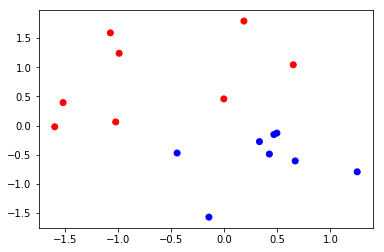

In [12]:
# generate color sequence
colors = []
for i in range(n):
    if s_best[i] == 1:
        colors.append('r')
    else:
        colors.append('b')

plt.scatter(X[0], X[1], 
            c = colors, 
            marker = 'o')

The possible clusters might be splitted by line y = 0 or x = 0 
because of the way I generated the data. This is consistent with what is introduced in papar.